# Sentiment Analysis across music genres
In this section we will perform sentiment analysis on the top songs of each genre. These genres are given in the *music_genre.txt* file, and in order to get the top songs and their lyrics we will use both the Spotify API through the *spotipy* package for searching and the Genius API through the *lyricsgenius* package to get lyrics.

In [52]:
import lyricsgenius
import json
import spotipy
from tqdm.auto import tqdm
import pandas as pd
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
import os
import re
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials

First of all, we prepare the client IDs for both the Spotify and Genius APIs. The *ids.txt* will not be provided unless given, but can easily be made by accessing the Spotify and Genius developer pages, requesting new IDs, and inserting them in the text file. The SPOTIPY_REDIRECT_URI should be *https://localhost:8888/callback*

In [2]:
with open('ids.txt') as f: 
    data = f.read() 
      
# reconstructing the data as a dictionary 
api_ips = json.loads(data)

SPOTIPY_CLIENT_ID = api_ips['SPOTIPY_CLIENT_ID']
SPOTIPY_CLIENT_SECRET = api_ips['SPOTIPY_CLIENT_SECRET']
SPOTIPY_REDIRECT_URI = api_ips['SPOTIPY_REDIRECT_URI']

GENIUS_CLIENT_ID = api_ips['GENIUS_CLIENT_ID']
GENIUS_CLIENT_SECRET = api_ips['GENIUS_CLIENT_SECRET']
GENIUS_ACCESS_TOKEN = api_ips['GENIUS_ACCESS_TOKEN']

os.environ['SPOTIPY_CLIENT_ID'] = SPOTIPY_CLIENT_ID
os.environ['SPOTIPY_CLIENT_SECRET'] = SPOTIPY_CLIENT_SECRET

Once the API client IDs are defined, we can begin reading the list of genres from the file *"music_genres.txt"*. We read one line at a time, in order to remove the newline symbol from the end of each line.

In [3]:
genres = []
with open ('music_genres.txt', 'r', encoding='utf-8') as f:
    while True:
        line = f.readline()

        # if line is empty
        # end of file is reached
        if not line:
            break

        genres.append(line[:-1])
print(genres[:10])

['Andalusian classical music', 'Indian classical music', 'Korean court music', 'Persian classical music', 'Western classical music', 'Early music', 'Medieval music', 'Ars antiqua', 'Ars nova', 'Ars subtilior']


Now we can begin working with the APIs! First of all we define a function that takes a genre and outputs a formattet version of that genre fit for search using the Spotify API. Additionally, we test how the API works with the *spotipy* package.

In [11]:
def genre_to_search_term(genre_name, version=2):
    match version:
        case 1:
            return "genre%:" + genre_name.replace(" ", "%20") # version 1
        case 2:
            return genre_name.replace(" ", "%20") # version 2
        case _:
            return None

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

for i in range(1,3):
    results = spotify.search(q=genre_to_search_term(genres[0], version=i), limit=5)
    #print(results['tracks']['items'][0])
    names = [(result['name'], result['artists'][0]['name'])  for result in results['tracks']['items']]
    print(names)

[('Andalusian Dance', 'Global Village Players'), ('Andalusian Guitar', 'Colima'), ('Andalusian Folk Song', 'Unspecified'), ('Andalusian Nights', 'Govi'), ('Persuasion', 'Govi')]
[('Andalusian Dance', 'Global Village Players'), ('Andalusian Guitar', 'Colima'), ('Andalusian Nights', 'Govi'), ('Andalusian Folk Song', 'Unspecified'), ('Persuasion', 'Govi')]


Now that we can extract the songs and the artists, we will create a dictionary that maps a genre to the name and artist of the top 5 search items. One thing that we have to take into account is that some of the will end up being unspecified, as shown in the third result with "Andalusian Folk Song". This will complicate things once we have to use the Genius API, but we will handle that.

In [75]:
genre_to_track = {}
TRACKS_PER_GENRE = 5
for genre in tqdm(genres):
    results = spotify.search(q=genre_to_search_term(genre), limit=TRACKS_PER_GENRE)
    genre_to_track[genre] = [(result['name'], result['artists'][0]['name'])  for result in results['tracks']['items']]
    
genre_to_track[genres[20]]

100%|██████████████████████████████████████████████████████████████████████████████| 1395/1395 [05:08<00:00,  4.52it/s]


[('Ofrenda a Falla', 'Jesús Arámbarri'),
 ('Flattery', 'The Modern Zolo'),
 ('Divertimento', 'Victorino Echevarría'),
 ('The Modern Things', 'Björk'),
 ('Aria Antigua', 'Joaquín Rodrigo')]

Now we can extract the lyrics of the search results. First of all we create a function that takes a list similar to the ones in *genre_to_track*, and returns a list with the song lyrics if possible. Since there is a risk of the Genius API failing to respond, we use while loops to repeat the API call until it succeeds.

In [76]:
def extract_lyric_list(track_list):
    genius_api = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN, verbose=False)
    results = []
    for track, artist in track_list:
        while True:
            try: #Retry the request until it goes through
                results.append(genius_api.search_song(track, artist))
                break
            except:
                pass
    return results
        
songs = extract_lyric_list(genre_to_track[genres[0]])

Now we make another function that takes the previous list of songs, and calculates an average sentiment score of those songs

In [77]:
def labMT_to_dict(path):
    df = pd.read_csv(path,sep='\t',skiprows=(0,1),header=(0))
    df = df.set_index('word').T
    d = df.iloc[1].to_dict()
    return d

print("Creating dictionary from labMT dataset...")
d = labMT_to_dict("Data_Set_S1.txt")
print("Done!")

def calculate_sentiment(d, tokens):
    '''
    INPUT:
    d: dictionary mapping words to sentiment scores
    tokens: list of tokens

    OUTPUT:
    float of overall sentiment score for list
    '''
    score = 0.0
    for token in tokens:
        try:
            score += d[token]
        except:
            # In case token does not exist in dictionary
            continue
    if len(tokens) != 0:
        return score/len(tokens)
    return None

def calc_sentiment(songs, no_none=False):
    avg_senti = 0.0
    not_none_length = sum(1 for item in songs if item is not None)
    if no_none and not_none_length != TRACKS_PER_GENRE:
        return -1.0
    for song in songs:
        if song is None:
            continue
        else:
            # Calculate sentiment score
            tokens = word_tokenize(song.lyrics)
            tokens = [x.lower() for x in tokens]
            r = re.compile("\w+")
            tokens = list(filter(r.match, tokens))

            sentiment_score = calculate_sentiment(d, tokens)
            # print(f"Sentiment score for {song.title}: {sentiment_score}")
            # Add it to avg_senti
            if sentiment_score != None:
                avg_senti += sentiment_score / not_none_length
                
    if avg_senti <= 0.0:
        # If no sentiment was calculated, indicate lack of lyrics with -1
        return -1.0
    return avg_senti
            
def genre_sentiment(genres, genre_to_track):
    genre_sentiments = {}
    for genre in tqdm(genres, position=0, leave=True):
        songs = extract_lyric_list(genre_to_track[genre])
        genre_sentiments[genre] = calc_sentiment(songs)
        
        #print(f"Avg. sentiment for {genre}: {genre_sentiments[genre]}")
    return genre_sentiments

genre_sentiments = genre_sentiment(genres, genre_to_track)

SyntaxError: expected ':' (2943081725.py, line 34)

In [ ]:
with open('genre_sentiments.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(genre_sentiments))

In [16]:
with open('genre_sentiments.txt') as f: 
    data = f.read() 
# genre_sentiments_v1 : First attempt at mapping genres to sentiments. Did not seem to get top results
# reconstructing the data as a dictionary 
genre_sentiments = json.loads(data)

In [ ]:
# CREATE WORD CLOUD FOR TOP 3 AND BOTTOM 3
# Discussion - Write about limitations of the data, time, computation
# Conclusions from graphs should happen in discussion and not results
# Compare with other papers and look at their results
# Explainer notebook should have most important conclusions and should describe figures
# Extremely important to follow the structure of the template
# Figures should have a preset size (and only that size)
# Comments in template is important to follow
# Materials and methods should explain how we obtained results and how we do stuff

In [74]:
def get_top_and_bottom(my_dict, n, min_value=None, max_value=None):
    # Filter dictionary items based on the specified range
    filtered_items = [(key, value) for key, value in my_dict.items() if (min_value is None or value >= min_value) and (max_value is None or value <= max_value)]

    # Get the top N values
    top_items = sorted(filtered_items, key=lambda item: item[1], reverse=True)[:n]

    # Get the bottom N values
    bottom_items = sorted(filtered_items, key=lambda item: item[1])[:n]

    # Extract keys and values for the top and bottom N items
    top_keys, top_values = zip(*top_items)
    bottom_keys, bottom_values = zip(*bottom_items)

    return top_keys, top_values, bottom_keys, bottom_values

n=5
min_value=0.1
max_value=None
top_keys, top_values, bottom_keys, bottom_values = get_top_and_bottom(genre_sentiments, n, min_value=min_value)

print(f"Top {n} genres with the happiest lyrics (maximum value of {max_value})")
for i in range(n):
    print(top_keys[i], ": %.3f" % top_values[i])
print(f"\nTop {n} genres with the saddest lyrics (minimum value of {min_value})")
for i in range(n):
    print(bottom_keys[i], ": %.3f" % bottom_values[i])

Top 5 genres with the happiest lyrics (maximum value of None)
Avant-prog : 5.590
Psychedelic soul : 5.522
Worship : 5.454
Post-hardcore : 5.432
Shibuya-kei : 5.418

Top 5 genres with the saddest lyrics (minimum value of 0.1)
Mahraganat : 0.151
Kyrgyz folk music : 0.153
Taiwanese rock : 0.329
Taiwanese pop : 0.404
Arabic rock : 0.489


In [36]:
genre_to_track['Psychedelic soul']

[('Psychedelic Soul - Progressive Fullon 2020 DJ Mixed', 'Raptor'),
 ('Psychedelic $uicide', 'Trezmane'),
 ('Splinter Soul - Psychedelic Rave 2017 DJ Mix Edit', 'Hidden Soul'),
 ('Psychedelic Soul', 'Soul Hooligan'),
 ('Splinter Soul - Psychedelic Rave 2017 DJ Mix Edit', 'Hidden Soul')]

We will now also create word clouds for these top and bottom sentiment score genres.

In [64]:
def tokenize_text(song, lemmatize=False):
    if song is None:
        return []
    tokens = word_tokenize(song.lyrics)
    tokens = [x.lower() for x in tokens]
    r = re.compile("\w+")
    tokens = list(filter(r.match, tokens))
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens
    
def combine_lyrics(genre):
    index = genres.index(genre)
    songs = extract_lyric_list(genre_to_track[genre])
    combined = ""
    for song in songs:
        if song is not None:
            combined += song.lyrics#tokenize_text(song, True)
        
    return combined
     
#combine_lyrics('Psychedelic soul')

In [65]:
stop_words = {'on', "mightn't", 'yours', 't', 'myself', 'did', 'as', 'more', 'haven', 'very', 'are', 'again', 'both', 'against', "wasn't", 'some', 'does', "didn't", 'above', 'for', 'having', 'by', 'during', 'same', 'further', 'under', 'when', 'wasn', 'they', 'be', 'm', "doesn't", 'each', 'd', 'of', "that'll", 'you', 'herself', 'ours', 'doesn', "isn't", 'all', "won't", 'himself', "couldn't", 'which', 'have', 'that', 'before', 'into', 'so', 'your', 'who', 'these', 'then', 'she', 'didn', 'do', 'we', 'my', 'to', 'after', 'most', 'should', 'me', "haven't", 'them', 'once', 'with', 'has', "don't", 'other', "mustn't", 'were', 'from', "shouldn't", 'aren', 'this', "weren't", 'doing', 'mightn', "you'd", "you'll", 'he', 'or', 'between', "you've", 'own', 'weren', 'am', 'if', 'ourselves', 'about', 'no', 'ma', 'but', "she's", 'our', 'any', 'was', 'been', 'their', 'will', 'needn', 've', 'is', 'll', 'wouldn', 'through', 'what', 'shan', "shan't", 'hadn', "it's", 'why', 'won', 'itself', 'in', 'those', 'off', 'her', "should've", 'mustn', 'here', 'at', 'until', 'ain', 'nor', 'yourselves', 's', 'don', 'its', 'i', 'a', 'it', 'out', 'such', 'just', 're', "hadn't", 'themselves', 'had', 'an', 'shouldn', "needn't", 'y', 'yourself', 'than', 'not', 'the', "hasn't", 'where', 'up', 'hers', "you're", 'because', 'down', 'can', 'and', "aren't", 'his', 'now', 'theirs', 'while', 'being', 'only', 'below', 'hasn', 'o', 'whom', "wouldn't", 'isn', 'how', 'few', 'there', 'couldn', 'too', 'him', 'over'}

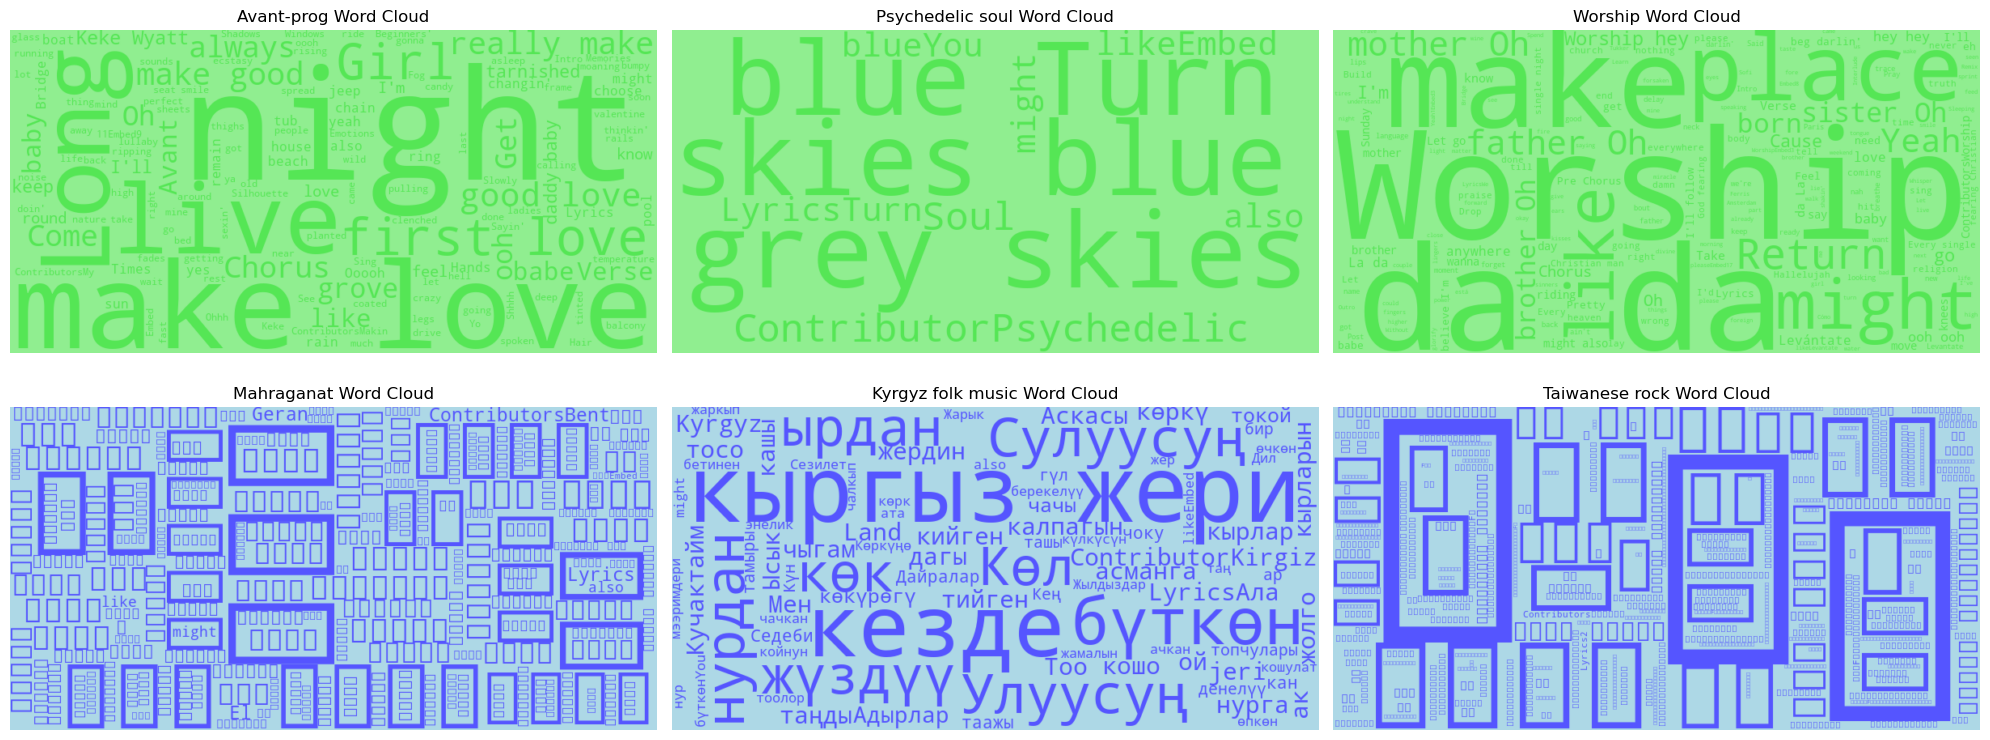

In [68]:
# Custom color functions
def color_func_happy(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(85, 230, 85)"

def color_func_sad(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(85, 85, 255)"

def create_word_cloud(tr_weights, color_func, background, ax, stop_words, title="Word Cloud"):
    cloud = WordCloud(stopwords=stop_words, width=800, height=400, max_words=200, background_color=background, color_func=color_func).generate(tr_weights)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(2,3 , figsize=(20, 8))
axs = axs.flatten()

# Word clouds for 
create_word_cloud(combine_lyrics('Avant-prog'), color_func_happy, 'lightgreen', axs[0], stop_words=stop_words, title="Avant-prog Word Cloud")
create_word_cloud(combine_lyrics('Psychedelic soul'), color_func_happy, 'lightgreen', axs[1], stop_words=stop_words, title="Psychedelic soul Word Cloud")
create_word_cloud(combine_lyrics('Worship'), color_func_happy, 'lightgreen', axs[2], stop_words=stop_words, title="Worship Word Cloud")
create_word_cloud(combine_lyrics('Mahraganat'), color_func_sad, 'lightblue', axs[3], stop_words=stop_words, title="Mahraganat Word Cloud")
create_word_cloud(combine_lyrics('Kyrgyz folk music'), color_func_sad, 'lightblue', axs[4], stop_words=stop_words, title="Kyrgyz folk music Word Cloud")
create_word_cloud(combine_lyrics('Taiwanese rock'), color_func_sad, 'lightblue', axs[5], stop_words=stop_words, title="Taiwanese rock Word Cloud")

plt.tight_layout()
plt.show()